# Proglearn: Scene Segmentation
*Neuro Data Design I: Spring 2022*


This tutorial provides a walkthrough to applying a Random Forest model based on Proglearn to perform scene segmentation on the ADE20K image dataset. First, we examine the accuracy of currently-used packages, after which we will work to use Proglearn.


**Contributor**: Amy van Ee (avanee1@jhu.edu)

# I. Preprocessing of Images

In this first section, we will import our images from the ISIC Challenge dataset.

In [1]:
#========================================================#
# retrieve data

import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt

# location of data
dataloc = 'C:/Users/Amy/Documents/Python/Neuro Data Design/'

# extract images
datalbl = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/'
dataimg = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/'

lblpaths = [datalbl+im for im in os.listdir(datalbl)]
imgpaths = [dataimg+im for im in os.listdir(dataimg)]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 1279
Total # of labels = 1279


(['C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000003.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000004.jpg'],
 ['C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000000_Segmentation.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000001_Segmentation.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000002_Segmentation.png',
  'C:/Users

# II. Current Methods of Scene Segmentation

To test other methods of scene segmentation before we attempt an implementation of ProgLearn, we will use scikit-image. 

**Visualize an Example Image**

We will choose a sample image from the ISIC dataset to confirm that this method works.

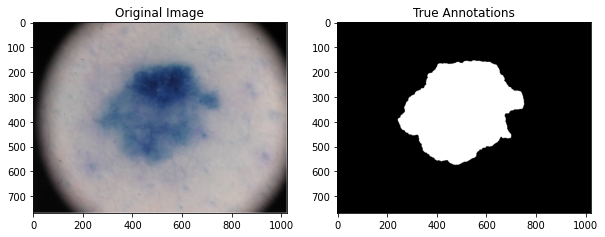

In [2]:
#========================================================#
# Plot the original image alongside the annotated image

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

image = cv2.imread(imgpaths[10])
label = cv2.imread(lblpaths[10]) 
ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(label)
ax[1].set_title("True Annotations")
plt.show()

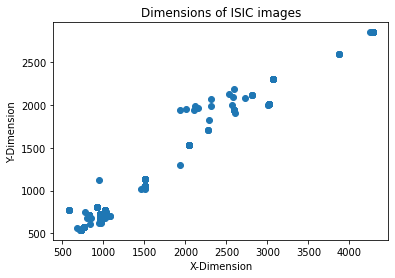

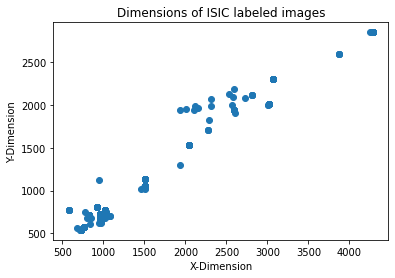

In [26]:
# get all images
images = [cv2.imread(imgpaths[i]) for i in np.arange(len(imgpaths))]
labels = [cv2.imread(lblpaths[i]) for i in np.arange(len(lblpaths))]

# get dimensions of dataset
xdim_images = [np.shape(img)[1] for img in images]
ydim_images = [np.shape(img)[0] for img in images]

xdim_labels = [np.shape(lbl)[1] for lbl in labels]
ydim_labels = [np.shape(lbl)[0] for lbl in labels]

# make a plot
plt.scatter(xdim_images, ydim_images)
plt.title("Dimensions of ISIC images")
plt.xlabel("X-Dimension")
plt.ylabel("Y-Dimension")
plt.show()

# make a plot
plt.scatter(xdim_labels, ydim_labels)
plt.title("Dimensions of ISIC labeled images")
plt.xlabel("X-Dimension")
plt.ylabel("Y-Dimension")
plt.show()

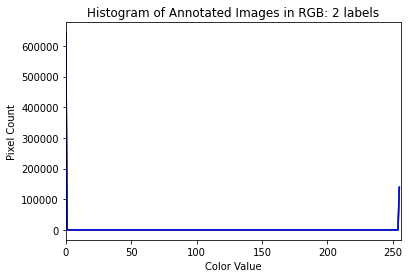

In [22]:
#========================================================#
# Show a histogram of the image

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        label[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.title("Histogram of Annotated Images in RGB: %d labels" %(np.unique(label).size))

plt.show()

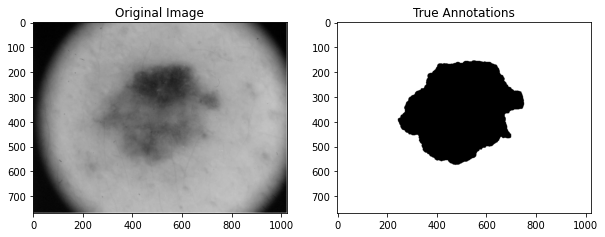

In [23]:
#========================================================#
# Convert to greyscale

from skimage.color import rgb2gray

image_grey = rgb2gray(image)
label_grey = rgb2gray(label)
label_grey = label_grey * 1000
label_grey = label_grey.astype(int)
label_grey = np.abs(label_grey - 1000) # dark corresponds to dark in original image

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

ax[0].imshow(image_grey, cmap = plt.cm.gray)
ax[0].set_title("Original Image")

ax[1].imshow(label_grey, cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

**Performing the Image Segmentation**

After this prepration and analysis of the images, we will now attempt to perform scene segmentation.

C:\Users\Amy\AppData\Local\Temp\ipykernel_69920\3899752176.py:17: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0.Please use `channel_axis` instead.
  features = features_func(img)


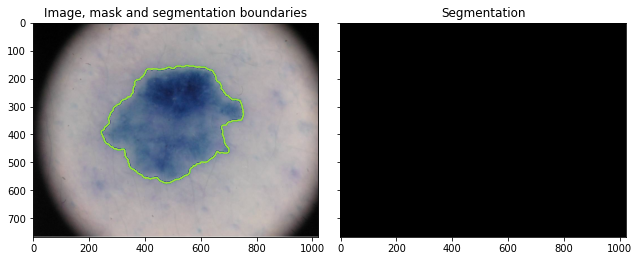

In [24]:
#========================================================#
# Use scikit-image to perform Image Segmentation

from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

img = image
training_labels = label_grey

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels) # contour is true label area
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation and the true annotated image.

Adapted Rand error: 0.0
Adapted Rand precision: 1.0
Adapted Rand recall: 1.0
False Splits: 1.3175923035896505e-16
False Merges: 0.6743242956615856
Dice Coefficient: 0.822614348734618


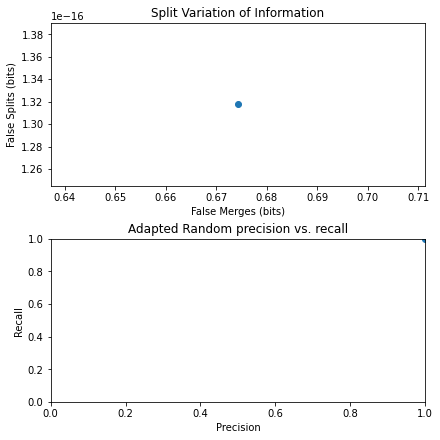

In [25]:
#========================================================#
# Analyze the accuracy by looking at 
# precision, recall, false splits, false merges, dice score

from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
def get_dice(true, test):
    return np.size(test[test == true]) * 2.0 / (np.size(true) + np.size(test))

error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)
print(f'Adapted Rand error: {error}')
print(f'Adapted Rand precision: {precision}')
print(f'Adapted Rand recall: {recall}')
print(f'False Splits: {splits}')
print(f'False Merges: {merges}')
print(f'Dice Coefficient: {dice}')

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merges, splits)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision, recall)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

Evidently, it appears that scikit-image did a poor job of scene segmentation. 

**Performing Scene Segmentation on entire dataset**

Next, we will try to perform scene segmentation on the entire dataset. 

In [22]:
#========================================================#
# convert all images to greyscale
images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])

C:\Users\Amy\AppData\Local\Temp\ipykernel_51368\721989578.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
C:\Users\Amy\AppData\Local\Temp\ipykernel_51368\721989578.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])


In [23]:
#========================================================#
# perform scene segmentation on all images

# initialize arrays
error_list = np.zeros(len(images_grey))
precision_list = np.zeros(len(images_grey))
recall_list = np.zeros(len(images_grey))
splits_list = np.zeros(len(images_grey))
merges_list = np.zeros(len(images_grey))
dice_list = np.zeros(len(images_grey))
result_list = np.zeros(len(images_grey), dtype = object)

# loop through each image and determine values
for i in np.arange(len(images_grey)):
    # use classifier
    features = features_func(images_grey[i])
    result = future.predict_segmenter(features, clf)

    # assess
    error, precision, recall = adapted_rand_error(images_grey[i], result)
    splits, merges = variation_of_information(images_grey[i], result)
    dice = get_dice(images_grey[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

NameError: name 'images_grey_match' is not defined

Text(0.5, 1.0, 'Histogram of Dice Coefficients')

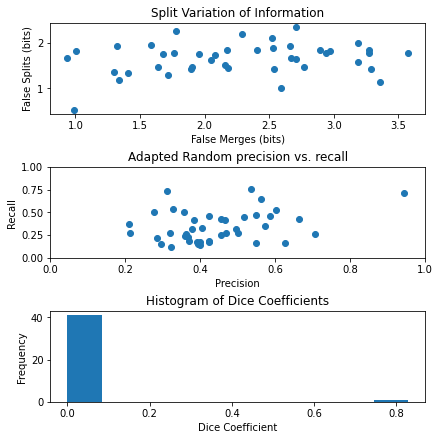

In [14]:
#========================================================#
# analyze results

fig, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merges_list, splits_list)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].hist(dice_list)
ax[2].set_xlabel('Dice Coefficient')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of Dice Coefficients')

Based on the results, it appears that scikit-image is only able to fit to one specific image at a time, and therefore only the image with the palm tree had high accuracy values, whereas the other images did not. 

**Looking at a Poorly Segmented Example**

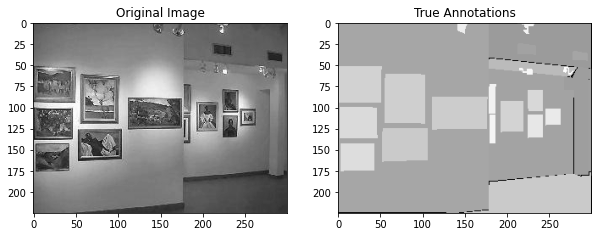

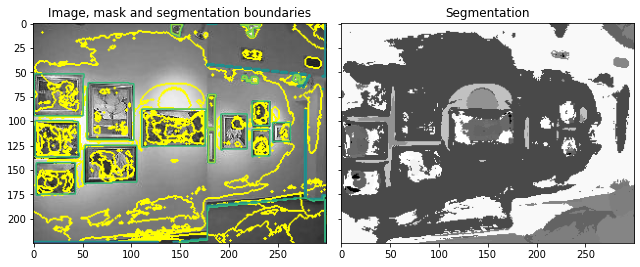

In [15]:
#========================================================#
# see low accuracy since had only trained on one image which has high dice coefficient

# original
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

ax[0].imshow(images_grey[1], cmap = plt.cm.gray)
ax[0].set_title("Original Image")

ax[1].imshow(images_grey[1], cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

# segmented
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(images_grey[1], result_list[1], mode='thick'))
ax[0].contour(images_grey[1])
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result_list[1], cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

This thus presents an opportunity for Proglearn to allow for improved and more generalizable scene segmentation.

# III. Proglearn for Scene Segmentation

We next proceed to use the example of scikit-image to apply Proglearn for scene segmentation. We will use the LifelongClassificationForest in place of the RandomForestClassifier.

In [16]:
#========================================================#
# perform a basic test using one task

from proglearn import LifelongClassificationForest

# define forest
progtree = LifelongClassificationForest()
progtree.add_task(images_grey_match[9], labels_grey_match[9])

# test prediction on a sample image
prediction = progtree.predict(images_grey_match[10], task_id = 0)
prediction_proba = progtree.predict_proba(images_grey_match[10], task_id = 0)

ValueError: y should be a 1d array, got an array of shape (1200, 1600) instead.

Unfortunately, in doing so we come across the error of dimensionality. Proglearn as it is implemented now only takes in a 1D array for the class label, whereas the dataset ADE20K consists of labels per pixel. Therefore, more work will need to be done to accommodate this specific dataset. An alternative approach will be to use another dataset where the labels are binary and therefore the problem is more simplified before we scale up to a more complex situation like the ADE20K dataset. 

Ultimately, we hope to be able to use Proglearn and test our scene segmentation implementation using more than one task. 